In [21]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, merge, Input, concatenate, add
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D
from keras.utils import np_utils
from keras.models import model_from_json
from keras import backend as K
from keras.preprocessing import image
from keras.optimizers import SGD, RMSprop
from keras.applications import InceptionV3
from keras.utils.data_utils import get_file
import random
import os
import cv2
from keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter("ignore", UserWarning)

In [5]:
from keras.preprocessing.image import ImageDataGenerator
image_width = 75
image_height = 75

img_rows =  224
img_cols =  224
image_size = (image_width, image_height)

data_datagen = ImageDataGenerator(rescale=1.0/255,  validation_split=0.20, featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1,
        width_shift_range=0.1, 
        height_shift_range=0.1,
        horizontal_flip=True,  
        vertical_flip=False)

train_generator = data_datagen.flow_from_directory(
        '../input/simpsons-dataset/simpsons_dataset/simpsons_dataset/',  # this is the target directory
        target_size=image_size,  # all images will be resized to 224x224
        batch_size=16,
        class_mode='categorical',
         subset='training')

validation_generator = data_datagen.flow_from_directory(
        '../input/simpsons-dataset/simpsons_dataset/simpsons_dataset/',  # this is the target directory
        target_size=image_size,  # all images will be resized to 224x224
        batch_size=16,
        class_mode='categorical',
         subset='validation', shuffle = False)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
       '../input/dataset-simpsons-test/kaggle_simpson_testset/',  # this is the target directory
        target_size=image_size,  # all images will be resized to 224x224
        batch_size=16,
        class_mode='categorical',shuffle = False)

Found 11054 images belonging to 10 classes.
Found 2757 images belonging to 10 classes.
Found 456 images belonging to 10 classes.


In [6]:
def create_model():
    inception = InceptionV3(include_top=False, input_shape=(75, 75, 3))
    
    model = Sequential()
    model.add(inception)
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.001,l2=0.001)))
    model.add(Dense(10, activation='softmax'))   
    model.summary()
    #sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['acc'])
    return model
    

In [8]:
model = create_model()

87916544/87910968 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 1, 1, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 22,329,898
Trainable params: 22,295,466
Non-trainable params: 34,432
_________________________________________________________________


In [9]:
n_train = 11054
batch_size = 16
n_valid = 2757
history = model.fit_generator(
       train_generator,
       steps_per_epoch=n_train//batch_size,
       epochs=100,
       validation_data=validation_generator,
       validation_steps=n_valid//batch_size)

Epoch 1/100
690/690 [==============================] - 174s 252ms/step - loss: 3.6829 - acc: 0.1538 - val_loss: 3.2505 - val_acc: 0.1632
Epoch 2/100
690/690 [==============================] - 155s 225ms/step - loss: 2.5750 - acc: 0.1837 - val_loss: 2.5155 - val_acc: 0.2313
Epoch 3/100
690/690 [==============================] - 155s 225ms/step - loss: 2.2915 - acc: 0.3075 - val_loss: 2.8707 - val_acc: 0.2915
Epoch 4/100
690/690 [==============================] - 155s 224ms/step - loss: 1.8551 - acc: 0.4744 - val_loss: 2.0723 - val_acc: 0.4476
Epoch 5/100
690/690 [==============================] - 154s 223ms/step - loss: 1.5223 - acc: 0.5971 - val_loss: 1.7978 - val_acc: 0.6228
Epoch 6/100
690/690 [==============================] - 155s 224ms/step - loss: 1.3259 - acc: 0.6752 - val_loss: 1.2870 - val_acc: 0.6910
Epoch 7/100
690/690 [==============================] - 154s 224ms/step - loss: 1.1537 - acc: 0.7361 - val_loss: 1.3991 - val_acc: 0.6676
Epoch 8/100
690/690 [====================

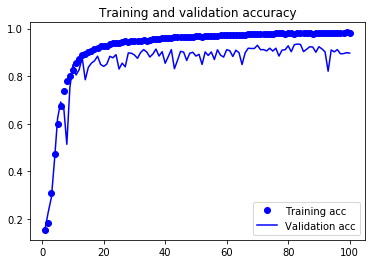

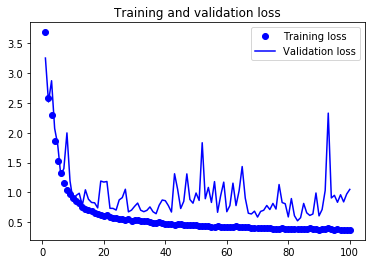

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend(loc='best')

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best');

In [11]:
n_test = 456
Y_pred = model.predict_generator(test_generator, n_test//16+1)
y_pred = np.argmax(Y_pred, axis=1)
#print(y_pred)


In [22]:
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)

Confusion Matrix


In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Classe Real')
    plt.xlabel('Classe Predita')
    plt.tight_layout()

Confusion matrix, without normalization
[[45  2  1  0  1  0  0  0  1  0]
 [ 0 36  0  0  0  0  0  0  0  0]
 [ 0  0 49  0  0  0  0  0  1  0]
 [ 0  0  0 42  0  0  0  0  0  0]
 [ 0  0  0  0 44  0  0  0  1  0]
 [ 0  0  0  0  0 49  0  0  1  0]
 [ 0 13  0  0  0  0 36  0  0  0]
 [ 0  0  0  0  0  0  0 42  1  1]
 [ 0  0  0  0  0  0  0  0 46  0]
 [ 0  0  0  0  0  0  0  0  2 42]]


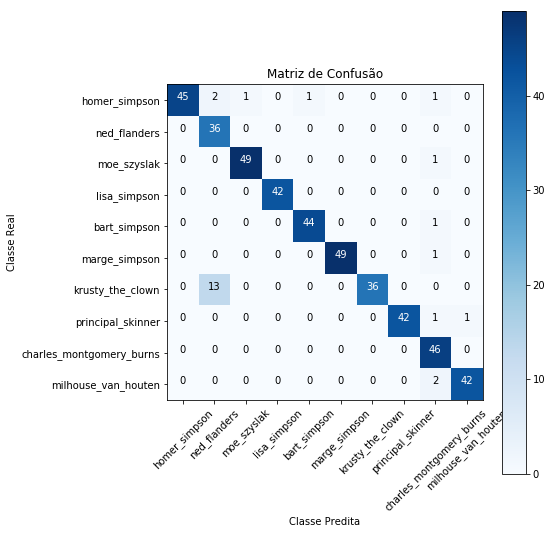

In [24]:
nomes_classes=['homer_simpson', 'ned_flanders', 'moe_szyslak', 'lisa_simpson','bart_simpson',
         'marge_simpson', 'krusty_the_clown', 'principal_skinner', 'charles_montgomery_burns', 'milhouse_van_houten']
plot_confusion_matrix(cm, classes=nomes_classes,
                      title='Matriz de Confusão')

In [25]:
target_names=['homer_simpson', 'ned_flanders', 'moe_szyslak', 'lisa_simpson', 
                 'bart_simpson', 'marge_simpson', 'krusty_the_clown', 
                 'principal_skinner', 'charles_montgomery_burns', 'milhouse_van_houten']
print (classification_report (test_generator.classes, y_pred, target_names = target_names))

                          precision    recall  f1-score   support

           homer_simpson       1.00      0.90      0.95        50
            ned_flanders       0.71      1.00      0.83        36
             moe_szyslak       0.98      0.98      0.98        50
            lisa_simpson       1.00      1.00      1.00        42
            bart_simpson       0.98      0.98      0.98        45
           marge_simpson       1.00      0.98      0.99        50
        krusty_the_clown       1.00      0.73      0.85        49
       principal_skinner       1.00      0.95      0.98        44
charles_montgomery_burns       0.87      1.00      0.93        46
     milhouse_van_houten       0.98      0.95      0.97        44

             avg / total       0.96      0.95      0.95       456

